In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline

from model.convlstm import ConvLSTM
from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Load specific variables for each dataset

In [3]:
%run dataset-variables.py

version = 4
dataset = ../data/dataset-chirps-1981-2019-seq5-ystep5.nc
input_size = 50
step = 5
dropout rate = 0.8
learning rate = 0.001
param = {'layer_size': 3, 'kernel_size': 5, 'hidden_dim': 32}


In [4]:
util = Util('ConvLSTM', version=version, dataset=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Seed

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Hyperparameters

In [7]:
epochs = 50
batch_size = 50
validation_split = 0.2
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [8]:
ds = xr.open_mfdataset(dataset_file)
#ds = ds[dict(sample=slice(0,500))]

In [9]:
train_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split)
val_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_validation=True)
test_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_test=True)

In [10]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [11]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [12]:
class STConvLSTM(nn.Module):
    def __init__(self, input_size, layer_size, kernel_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.convlstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        input_dim = 1
        for i in range(layer_size):
            self.convlstm_layer.append(
                ConvLSTM(input_size=(input_size,input_size), input_dim=input_dim, 
                        hidden_dim=hidden_dim, kernel_size=(kernel_size,kernel_size), num_layers=1, 
                        bias=False, return_all_layers=True, batch_first=True)
            )
            input_dim = hidden_dim
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(num_features=hidden_dim))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
        
        self.conv_layer = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, batch, drop in zip(self.convlstm_layer, self.relu_layers, 
                                         self.batch_layers, self.dropout_layers):
            x, hidden = convlstm(x)
            x = batch(x[0])
            x = relu(x)
            x = drop(x)
            
        out = self.conv_layer(x)
        return out

In [13]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [14]:
model = STConvLSTM(input_size, layer_size, kernel_size, hidden_dim).to(device)

criterion = RMSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, eps=1e-6)

Training the model

In [15]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                          device, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename)

Train on 8376 samples, validate on 2792 samples
Epoch: 1/50 - loss: 6.8966 - val_loss: 6.5465
=> Saving a new best
Epoch: 2/50 - loss: 6.6299 - val_loss: 6.5019
=> Saving a new best
Epoch: 3/50 - loss: 6.5951 - val_loss: 6.4462
=> Saving a new best
Epoch: 4/50 - loss: 6.5748 - val_loss: 6.5109
Epoch: 5/50 - loss: 6.5641 - val_loss: 6.4407
=> Saving a new best
Epoch: 6/50 - loss: 6.5553 - val_loss: 6.4461
Epoch: 7/50 - loss: 6.5466 - val_loss: 6.5081
Epoch: 8/50 - loss: 6.5427 - val_loss: 6.5325
Epoch: 9/50 - loss: 6.5365 - val_loss: 6.4364
=> Saving a new best
Epoch: 10/50 - loss: 6.5353 - val_loss: 6.4326
=> Saving a new best
Epoch: 11/50 - loss: 6.5316 - val_loss: 6.4393
Epoch: 12/50 - loss: 6.5291 - val_loss: 6.4340
Epoch: 13/50 - loss: 6.5282 - val_loss: 6.4383
Epoch: 14/50 - loss: 6.5244 - val_loss: 6.4437
Epoch: 15/50 - loss: 6.5233 - val_loss: 6.4551
Epoch: 16/50 - loss: 6.5225 - val_loss: 6.4204
=> Saving a new best
Epoch: 17/50 - loss: 6.5199 - val_loss: 6.4246
Epoch: 18/50 - 

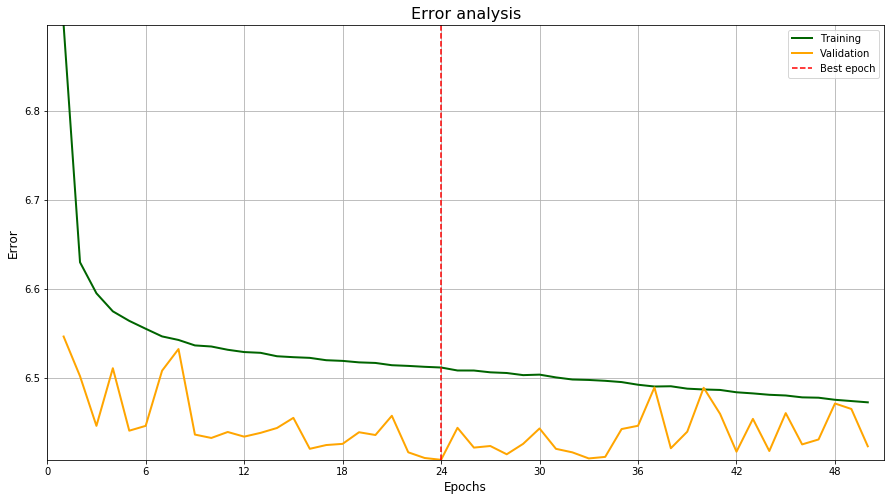

In [16]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Error', 'Error analysis', inline=True)

In [17]:
model,_, best_epoch, val_loss = trainer.load_checkpoint(checkpoint_filename)

=> Loaded checkpoint chirps_4_20190929-062123.pth.tar (best epoch: 24, validation error: 6.4080)


Evaluating the model

In [18]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.eval()
loss_type = type(criterion).__name__
print(f'ConvLSTM {loss_type}: {test_loss:.4f}')

ConvLSTM RMSELoss: 6.3794


In [19]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [21]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'layer': layer_size,
              'kernel_size': kernel_size,
              'filter': hidden_dim,
              'dropout_rate': dropout_rate,
              'learning_rate': lr,
              'dataset': dataset,
              'hostname': platform.node()}

In [22]:
util.send_email(model_info)

4662.412742614746
email sent
